# Linear Inverted Pendulum with Wall, Hybrid MPC Demo

This is a demo for the Model Predictive Control (MPC) package $\texttt{mpc_tools}$.

In [1]:
%load_ext autoreload
%autoreload 2
#%pylab notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from control import MPCHybridController
from dynamical_systems import DTLinearSystem, DTAffineSystem, DTPWASystem, plot_input_sequence, plot_state_trajectory, plot_state_space_trajectory
from geometry import Polytope

We stabilize a linear inverted pendulum with mass $m$ and length $l$, subject to the gravity acceleration $g$. The pendulum is allowed to impact with an elastic wall (with stiffness $k$) placed at distance $d$ from the vertical line passing trough the hinge.

In [3]:
m = 1.
l = 1.
g = 10.
k = 1000.
d = .1
t_s = .01

We express the linearized dynamics in PieceWise Affine (PWA) form:
\begin{equation}
\dot x =
\begin{cases}
A_1 x + B_1 u + c_1, \quad \text{if} \quad (x, u) \in \mathcal D_1, \\
A_2 x + B_2 u + c_2, \quad \text{if} \quad (x, u) \in \mathcal D_2,
\end{cases}
\end{equation}

with

\begin{equation}
A_1 = 
\begin{bmatrix}
0 & 1 \\ g/l & 0
\end{bmatrix},
\quad
B_1 = 
\begin{bmatrix}
0 \\ 1/(ml^2)
\end{bmatrix},
\quad
c_1 = 
\begin{bmatrix}
0 \\ 0
\end{bmatrix},
\end{equation}

\begin{equation}
\mathcal D_1 =
\{ (x,u) \ | \ x_1 \leq d/l, \ x_{min} \leq x \leq x_{max}, \ u_{min} \leq u \leq u_{max} \},
\end{equation}

\begin{equation}
A_2 = 
\begin{bmatrix}
0 & 1 \\ g/l - k/m & 0
\end{bmatrix},
\quad
B_2 = 
\begin{bmatrix}
0 \\ 1/(ml^2)
\end{bmatrix},
\quad
c_2 = 
\begin{bmatrix}
0 \\ kd/(ml)
\end{bmatrix},
\end{equation}

\begin{equation}
\mathcal D_2 =
\{ (x,u) \ | \ x_1 > d/l, \ x_{min} \leq x \leq x_{max}, \ u_{min} \leq u \leq u_{max} \},
\end{equation}


The discrete-time PWA system can be defined from its continuous-time representation setting a sampling time $t_s$ (the exact zero-order-hold discretization is used).

In [4]:
A_1 = np.array([[0., 1.],[g/l, 0.]])
B_1 = np.array([[0.],[1/(m*l**2.)]])
c_1 = np.array([[0.],[0.]])
sys_1 = DTAffineSystem.from_continuous(t_s, A_1, B_1, c_1)

A_2 = np.array([[0., 1.],[g/l-k/m, 0.]])
B_2 = B_1
c_2 = np.array([[0.],[k*d/(m*l)]])
sys_2 = DTAffineSystem.from_continuous(t_s, A_2, B_2, c_2)

sys = [sys_1, sys_2]

In [5]:
x_max_1 = np.array([[d/l], [1.5]])
x_max_2 = np.array([[d/l*2.],[x_max_1[1,0]]])
x_min_1 = -x_max_2
x_min_2 = np.array([[x_max_1[0,0]], [x_min_1[1,0]]])

X_1 = Polytope.from_bounds(x_max_1, x_min_1)
X_1.assemble()
X_2 = Polytope.from_bounds(x_max_2, x_min_2)
X_2.assemble()
X = [X_1, X_2]

u_max = np.array([[4.]])
u_min = -u_max

U_1 = Polytope.from_bounds(u_max, u_min)
U_1.assemble()
U_2 = U_1
U = [U_1, U_2]

In [6]:
pwa_sys = DTPWASystem(sys, X, U)

At each each step, the following optimal control is solved
\begin{align}
\min \quad &
\sum_{k=0}^{N-1} (x_k^T Q x_k + u_k^T R u_k) + x_N^T P x_N \\
\text{subject to} \quad &
x_{k+1} =
\begin{cases}
A_1 x_k + B_1 u_k + c_1, \quad \text{if} \quad (x_k, u_k) \in \mathcal D_1, \\
A_2 x_k + B_2 u_k + c_2, \quad \text{if} \quad (x_k, u_k) \in \mathcal D_2,
\end{cases}, \\
& (x_k, u_k) \in \mathcal D_1 \cup \mathcal D_2, \quad k = 1,2,\ldots,N-1, \\
& x_N \in \mathcal X_N, \\
& x_0 \ \text{given}, \\
\end{align}
and the input $u_0$ is applied to the system.

In [7]:
N = 8
Q = np.eye(A_1.shape[0])
R = np.eye(B_1.shape[1])

lin_sys_1 = DTLinearSystem.from_continuous(t_s, A_1, B_1)
P, K = lin_sys_1.dare(Q, R)
X_N = lin_sys_1.moas(K, X_1, U_1)


controller = MPCHybridController(pwa_sys, N, Q, R, P, X_N)

In [8]:
N_sim = 100
x_0 = np.array([[-.199],[1.35]])
u = []
x = []
x.append(x_0)
for k in range(0, N_sim):
    u.append(controller.feedback(x[k]))
    x_next = pwa_sys.simulate(x[k], [u[k]])[0][1]
    x.append(x_next)

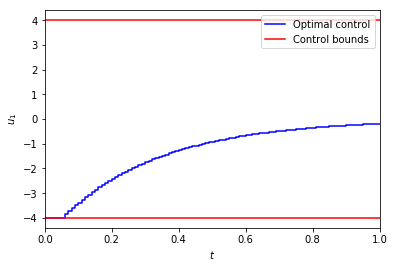

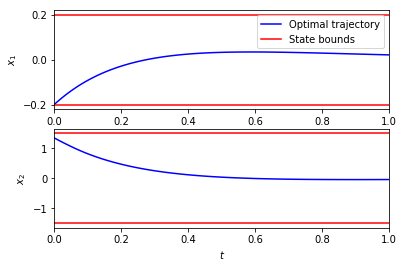

In [9]:
plot_input_sequence(u, t_s, N_sim, u_max, u_min)
plt.show()
plot_state_trajectory(x, t_s, N_sim, x_max_2, x_min_1)
plt.show()

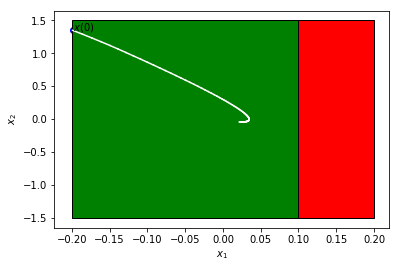

In [10]:
X_1.plot(facecolor='g')
X_2.plot(facecolor='r')
plot_state_space_trajectory(x, color='w')
plt.show()

[0, 0, 0, 0, 0, 0, 0, 0]
Feasible set computed in 0.372303009033 s
[0, 0, 0, 0, 0, 0, 0, 1]
Feasible set computed in 0.0791039466858 s
[0, 0, 0, 0, 0, 0, 1, 0]
Feasible set computed in 0.10217499733 s
[0, 0, 0, 0, 0, 1, 0, 0]
Feasible set computed in 0.114741802216 s
[0, 0, 0, 0, 1, 0, 0, 0]
Feasible set computed in 0.135444879532 s
[0, 0, 0, 1, 0, 0, 0, 0]
Feasible set computed in 0.153648853302 s
[0, 0, 1, 0, 0, 0, 0, 0]
Feasible set computed in 0.200871944427 s
[0, 1, 0, 0, 0, 0, 0, 0]
Feasible set computed in 0.267329931259 s
[1, 0, 0, 0, 0, 0, 0, 0]
Feasible set computed in 0.289832115173 s
[0, 0, 0, 0, 0, 0, 1, 1]
Feasible set computed in 0.0616981983185 s
[0, 0, 0, 0, 0, 1, 1, 0]
Feasible set computed in 0.100321054459 s
[0, 0, 0, 0, 1, 1, 0, 0]
Feasible set computed in 0.145962953568 s
[0, 0, 0, 1, 1, 0, 0, 0]
Feasible set computed in 0.148736953735 s
[0, 0, 1, 1, 0, 0, 0, 0]
Feasible set computed in 0.198886871338 s
[0, 1, 1, 0, 0, 0, 0, 0]
Feasible set computed in 0.228771924

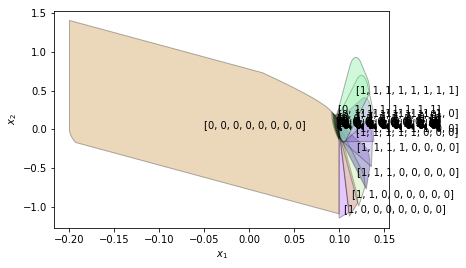

Optimal active set for x_0 = [-0.199  1.35 ] is [0, 0, 0, 0, 0, 0, 0, 0]


In [11]:

alpha = .3
ss = [0]*N
print ss
controller.plot_feasible_set(ss, facecolor=np.random.rand(3,1),alpha=alpha)

for len_contact in range(1,N+1):
    ss = [0]*(N-len_contact) + [1]*len_contact
    col = np.random.rand(3,1)
    for i in range(N-len_contact+1):
        print ss
        controller.plot_feasible_set(ss, facecolor=np.random.rand(3,1),alpha=alpha)
        del ss[0]
        ss += [0]
plt.show()

u = controller.feedforward(x_0)
act_set = pwa_sys.simulate(x_0, u)[1]

print('Optimal active set for x_0 = ' + str(x_0.flatten()) + ' is ' + str(act_set))